# 1. Setup And Load Data

In [2]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
from skimage.measure import find_contours
from skimage.io import imread
import random
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset
from dataset import SegmentationDataset

In [ ]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_built() and torch.backends.mps.is_available():
    device = torch.device("mps")
print(device)

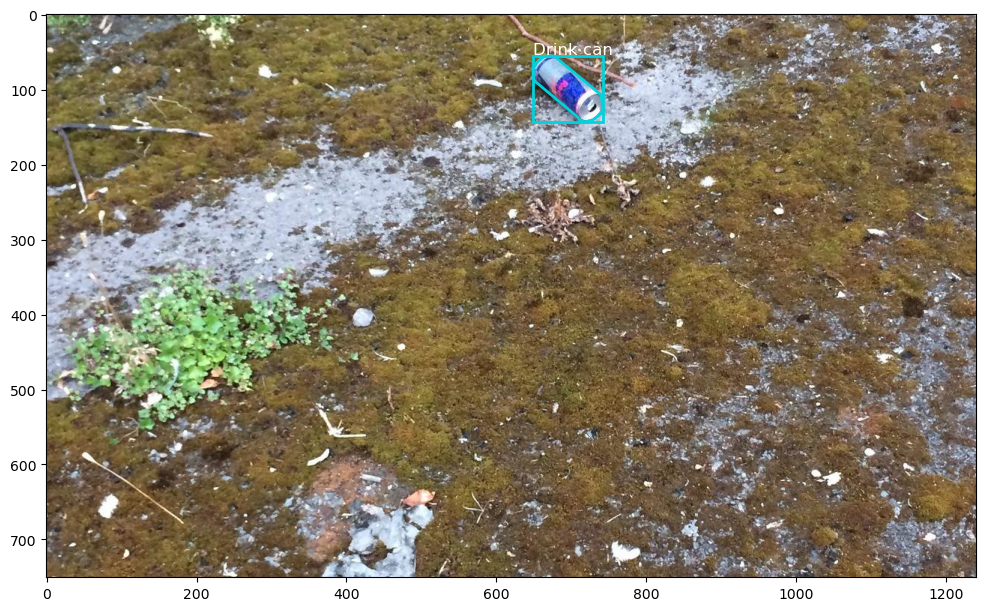

In [14]:
with open('./data/annotations.json') as f:
    data = json.load(f)

def random_colors(N):
    np.random.seed(1)
    colors = np.random.rand(N, 3)
    return colors

def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] * (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def find_contours(mask, level):
    return find_contours(mask, level)

def display_image_with_annotations(image_info, annotations, categories):
    img = imread("./data/" + image_info['file_name'])

    _, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(img)

    colors = random_colors(len(annotations))

    for i, ann in enumerate(annotations):
        if ann['image_id'] == image_info['id']:
            bbox = ann['bbox']
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2,
                                     edgecolor=colors[i], facecolor='none')
            ax.add_patch(rect)

            for seg in ann['segmentation']:
                seg = [seg[i:i+2] for i in range(0, len(seg), 2)]
                poly = patches.Polygon(seg, linewidth=2, edgecolor=colors[i], facecolor='none')
                ax.add_patch(poly)
                    
                mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
                seg_np = np.array(seg, dtype=np.int32)
                rr, cc = seg_np[:, 1], seg_np[:, 0]
                rr = np.clip(rr, 0, img.shape[0] - 1)
                cc = np.clip(cc, 0, img.shape[1] - 1)
                mask[rr, cc] = 1
                img = apply_mask(img, mask, colors[i])

            category_id = ann['category_id']
            category_name = next(cat['name'] for cat in categories if cat['id'] == category_id)
            ax.text(bbox[0], bbox[1] - 2, category_name, color='w', fontsize=12, backgroundcolor="none")
    
    ax.imshow(img)
    plt.show()

image_info = random.choice(data['images'])
annotations = data['annotations']
categories = data['categories']
display_image_with_annotations(image_info, annotations, categories)


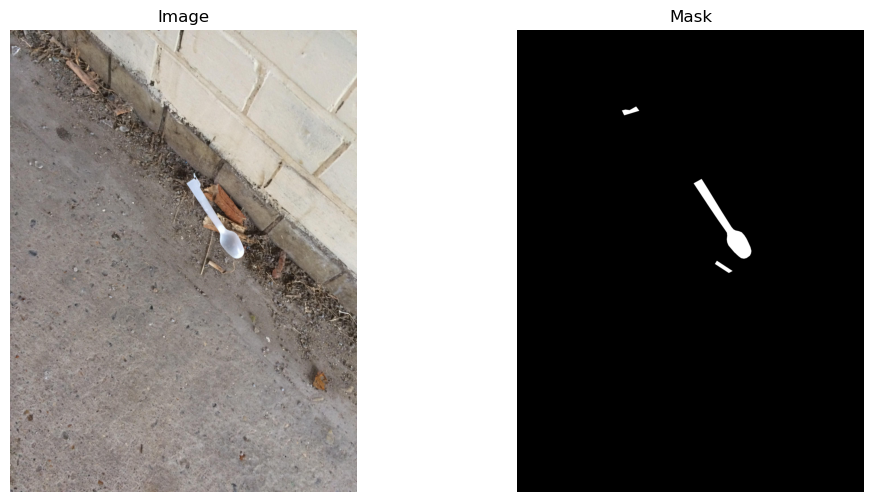

In [4]:
dataset = SegmentationDataset(annotations_file='annotations.json')

def visualize_sample(dataset, idx):
    image, mask = dataset[idx]

    if torch.is_tensor(image):
        image = image.permute(1, 2, 0).numpy()
    if torch.is_tensor(mask):
        mask = mask.numpy()

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image)
    ax[0].set_title('Image')
    ax[0].axis('off')

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Mask')
    ax[1].axis('off')

    plt.show()

visualize_sample(dataset, random.randint(0, len(dataset) - 1))